## Group 3 ##
Names: \
Quirine Japikse (5040930)\
Naomi Cornelissen (5105765)\
Kristian Terlien (5169941)

In [135]:
#import necessary libraries
import pandas as pd
import os
from itertools import combinations
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from gurobipy import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
from matplotlib import cm
from matplotlib.colors import Normalize
from pyproj import Geod

In [118]:
#create dictionary of airport data
#import the data
demand = 'DemandGroup3.xlsx'
df1 = pd.read_excel(demand, header=None)

#clean the dataframe
df1 = df1.drop(df1.index[9:12])
df1 = df1.drop(df1.index[0:3])
df1 = df1.drop(df1.columns[0], axis=1)
#df1 = df1.reset_index()

#make a list of airport names
airport_names = df1.iloc[0, 1:].dropna().tolist()
airport_codes = df1.iloc[1,1:].tolist()
#make a list of keys 
keys = df1.iloc[1:, 0].dropna().tolist()

#create dictionaries for each airport
airport_dictionaries = {}
for i, airport in enumerate(airport_codes):
# Extract values 
    values = df1.iloc[1:,i+1].dropna().tolist()
    # Map keys to values
    airport_dictionaries[airport] = dict(zip(keys, values))

In [3]:
#add population data to airports
#import population data
population = 'pop.xlsx'
df2 = pd.read_excel(population, header=None)

#make lists of additional data
pop20 = df2.iloc[3:,1].tolist()
pop23 = df2.iloc[3:,2].tolist()
gdp20 = df2.iloc[3:,5].tolist()
gdp23 = df2.iloc[3:,6].tolist()

for i, airport in enumerate(airport_codes):
    # Map keys to values
    airport_dictionaries[airport]['pop20'] = pop20[i]
    airport_dictionaries[airport]['pop23'] = pop23[i]
    airport_dictionaries[airport]['gdp20'] = gdp20[i]
    airport_dictionaries[airport]['gdp23'] = gdp23[i]

In [4]:
#Make a dataset for all OD pairs to estimate an OLS regression model using 2020 data
#create a list of sets of possible pairs
pairs = list(combinations(airport_codes, 2))

#Calculate demand between pairs
demands = []
for pair in range(len(pairs)):
    demands.append(airport_dictionaries[pairs[pair][0]][pairs[pair][1]])

#Calculate product of population
population_product = []
for pair in range(len(pairs)):
    population_product.append(airport_dictionaries[pairs[pair][0]]['pop20']*airport_dictionaries[pairs[pair][1]]['pop20'])
    
#Calculate product of GDP
gdp_product = []
for pair in range(len(pairs)):
    gdp_product.append(airport_dictionaries[pairs[pair][0]]['gdp20']*airport_dictionaries[pairs[pair][1]]['gdp20'])



In [5]:
#Create a function to calculate the distance between two airports using the coordinates in degrees
def calculate_distance(phi1, phi2, lamda1, lamda2):
    R_E = 6371 #km
    phi1 = np.radians(phi1)
    phi2 = np.radians(phi2)
    lamda1 = np.radians(lamda1)
    lamda2 = np.radians(lamda2)
    sigma = 2* np.arcsin(np.sqrt(np.sin((phi1 - phi2)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin((lamda1 - lamda2)/2)**2))
    d_ij = R_E * sigma
    return float(d_ij)

In [6]:
#Calculate distance
distance = []
for pair in range(len(pairs)):
    distance.append(calculate_distance(airport_dictionaries[pairs[pair][0]]['Latitude (deg)'],
                                       airport_dictionaries[pairs[pair][1]]['Latitude (deg)'],
                                       airport_dictionaries[pairs[pair][0]]['Longitude (deg)'],
                                       airport_dictionaries[pairs[pair][1]]['Longitude (deg)']))
distance = np.array(distance)

In [7]:
#estimate OLS model
f = 1.42 #€/gallon fuel costs
#create dataset
ols_data = {
    'population_product': np.log(population_product),
    'gdp_product': np.log(gdp_product),
    'distance': np.log(f) + np.log(distance),
    'demand': np.log(demands) #dependent variable
}

ols_df = pd.DataFrame(ols_data)

In [8]:
# Define independent variables (X) and dependent variable (Y)
X = ols_df[['population_product', 'gdp_product', 'distance']] 
Y = ols_df['demand']  

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X, Y)

# Coefficients and intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Predict values
predictions = model.predict(X)
print("Predicted values:", predictions)

Intercept: -16.3862350654871
Coefficients: [ 0.58638073  0.63171159 -1.24424231]
Predicted values: [ 7.18466786  6.60962763  5.71702539  5.62860045  5.33123691  5.65847551
  5.45001298  6.12608816  4.98271261  4.02904107  6.17053776  4.40197896
  4.49359179  5.717942    3.84947441  2.80213011  3.36943321  4.31315834
  3.11970374  5.79197794  5.45885274  5.09687065  4.96459464  5.33301613
  5.06014717  4.70418476  4.19163001  3.37858907  5.57703634  3.6427828
  3.87860142  4.38387853  3.28179075  2.23315111  2.43317235  3.84645124
  2.41753752  5.21693895  4.20895754  4.01204124  4.87092346  4.36184737
  4.26634122  4.0576717   2.60069471  5.56294389  3.42217252  3.63087884
  4.21949526  2.83336005  1.69233157  2.05729     3.17709175  1.74990337
  4.05835029  3.98555471  5.67969746  4.55452734  3.62105401  3.79951693
  2.39833051  5.7425843   3.22470567  3.70315627  3.49027137  2.9076122
  1.70731395  1.66908602  3.26318227  1.54270228  5.7146549   4.38793248
  4.85892155  3.9708913   3

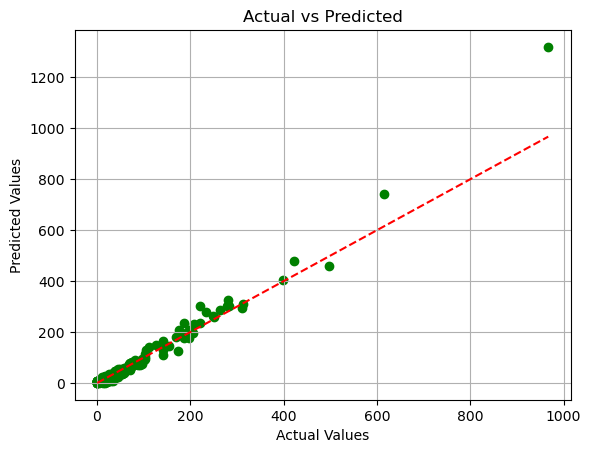

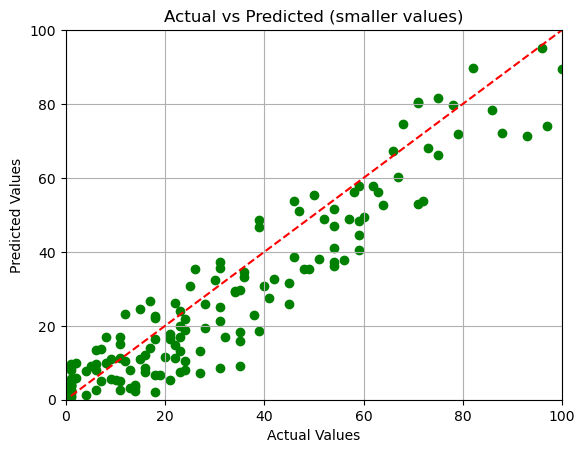

In [9]:
#plot actual agains predicted values

# Sample data
actual = demands
predicted = np.exp(predictions)

# Scatter plot for all values
plt.figure()
plt.scatter(actual, predicted, color='green')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.title('Actual vs Predicted')
plt.show()

# Scatter plot zoomed in on the smaller values
plt.figure()
plt.scatter(actual, predicted, color='green')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.title('Actual vs Predicted (smaller values)')
plt.show()

In [10]:
#calculate the values for population and gdp for 2025
annual_growth_pop = (np.array(pop23) - np.array(pop20))/3
pop25 = np.array(pop23) + 2*annual_growth_pop

annual_growth_gdp = (np.array(gdp23) - np.array(gdp20))/3
gdp25 = np.array(gdp23) + 2*annual_growth_gdp

#Add to dictionaries
for i, airport in enumerate(airport_codes):
    # Map keys to values
    airport_dictionaries[airport]['pop25'] = pop25[i]
    airport_dictionaries[airport]['gdp25'] = gdp25[i]

In [11]:
#Calculate product of population
population_product25 = []
for pair in range(len(pairs)):
    population_product25.append(airport_dictionaries[pairs[pair][0]]['pop25']*airport_dictionaries[pairs[pair][1]]['pop25'])
    
#Calculate product of GDP
gdp_product25 = []
for pair in range(len(pairs)):
    gdp_product25.append(airport_dictionaries[pairs[pair][0]]['gdp25']*airport_dictionaries[pairs[pair][1]]['gdp25'])

In [12]:
ols_data_25 = pd.DataFrame({
    'population_product': np.log(population_product25),
    'gdp_product': np.log(gdp_product25),
    'distance': np.log(f*distance),
})
predictions2025 = model.predict(ols_data_25)
predictions2025 = np.exp(predictions2025)
print("Predicted Values:", predictions2025)

Predicted Values: [1.36130328e+03 8.51547280e+02 3.78998523e+02 2.73341598e+02
 2.03939264e+02 3.61190288e+02 2.34975389e+02 7.66559966e+02
 1.75289870e+02 6.15152310e+01 6.03240164e+02 9.48364009e+01
 1.09186092e+02 3.47738202e+02 6.36207286e+01 1.26886572e+01
 5.33162102e+01 7.41460437e+01 2.22013031e+01 3.23102955e+02
 2.51621342e+02 1.38042026e+02 1.21479514e+02 2.24193886e+02
 1.36753584e+02 1.58947700e+02 6.83009784e+01 2.75884855e+01
 2.86397200e+02 3.81498889e+01 5.07356595e+01 7.87243193e+01
 3.09948594e+01 6.17368030e+00 1.79671527e+01 3.99606532e+01
 9.45506384e+00 2.19622240e+02 6.31518724e+01 5.20960784e+01
 1.57011022e+02 7.56243478e+01 1.14049106e+02 6.64110340e+01
 1.40891016e+01 3.13934588e+02 3.40152856e+01 4.40270347e+01
 7.42521169e+01 2.20054050e+01 3.99631643e+00 1.37159629e+01
 2.27469993e+01 5.39144662e+00 5.90281691e+01 5.51293734e+01
 3.83051532e+02 9.96374190e+01 6.50022199e+01 5.57450135e+01
 1.25048540e+01 4.08260145e+02 3.03386558e+01 5.14268709e+01
 3.891

In [13]:
#Make a dictionary mapping the distances to the pairs
pair_distances = dict(zip(pairs, distance))

#Make a dictionary mapping the demand to the pair
pair_demands = dict(zip(pairs, predictions2025))

In [14]:
#Make a matrix of all airports
distance_airport_matrix = np.zeros((20, 20))

#Calculate the distance of the pairs
for a1, a2 in pairs:    
    i, j = airport_codes.index(a1), airport_codes.index(a2)
    distance_airport_matrix[i, j] = pair_distances[(a1,a2)]  # Mark connection
    distance_airport_matrix[j, i] = pair_distances[(a1,a2)]  # Since connections are bidirectional

#Convert to Pandas DataFrame for better readability
df_airport_matrix = pd.DataFrame(distance_airport_matrix, index=airport_codes, columns=airport_codes)


In [15]:
#Make a matrix for the demand    
demand_airport_matrix = np.zeros((20, 20))

#Calculate the demands of the pairs
for a1, a2 in pairs:    
    i, j = airport_codes.index(a1), airport_codes.index(a2)
    demand_airport_matrix[i, j] = pair_demands[(a1,a2)] 
    demand_airport_matrix[j, i] = pair_demands[(a1,a2)] 

#Runway length airports
r_length = np.zeros(20)
for i in airport_codes:
    r_length[airport_codes.index(i)] = airport_dictionaries[i]['Runway (m)']

#Airport slots
slots= np.zeros(20)
for i in airport_codes:
    if i != 'LEMF':
        slots[airport_codes.index(i)] = airport_dictionaries[i]['Available slots']

In [16]:
# Parameters

# Data on aircrafts
aircraft = [1, 2, 3, 4] #Set of aircraft
s = [45, 70, 150, 320] #Seats
V = [550, 820, 850, 870] #Speed in km/h
TAT = [25, 35, 45, 60] #Min turnaround time in minutes
r = [1500, 3300, 6300, 12000] #Max range in km of aircraft
rr = [1400, 1600, 1800, 2600] #Required runway for a specific aircraft
c = [15000, 34000, 80000, 190000] #Weekly leasing costs
c_x = [300, 600, 1250, 2000] #Fixed costs per aircraft
c_t = [750, 775, 1400, 2800] #Time based costs /h
c_f = [1, 2, 3.75, 9] #Fuel cost parameter
BT = 10 * 7  #hours per day
LF = 0.75 #Load factor in an aircraft     

# Data on airports
Airports = airport_codes #List of airports
airports = range(len(Airports)) #Number of airports
r_length = r_length #Runway length at specific airport

#General data
d = distance_airport_matrix #Distance between airports  
q = demand_airport_matrix #Demand for flight between airport i and airport j
a = np.zeros((20,20,4)) #Empty array
g = np.ones(20) #Initialize array for hub parameter
g[4] = 0 #Madrid is our hub


# Calculating costs for use in model
c_ops = np.zeros((20,20,4)) #empty array for operational costs 

#Calculate operational costs for each aircraft and each OD-pair
for k in range(len(aircraft)):
    for i in airports:
        for j in airports:
            if i != j:
                c_ops[i][j][k] = (c_x[k]) + (c_t[k]*d[i][j]/V[k]) + (((c_f[k]*f)/1.5)*d[i][j])

#Flights departing or arriving at hub madrid have lower costs
for k in range(len(aircraft)):
    for i in airports:
        for j in airports:
            if i != j:
                if i == 4 or j == 4:
                    c_ops[i][j][k] = 0.7 * c_ops[i][j][k]

#Yield per OD pair
y = np.zeros((20,20))
for i in airports:
    for j in airports:
        if i !=j:
            y[i][j] = 5.9 * (d[i][j] **-.76) + 0.043 

In [17]:
# Start modelling optimization problem
m = Model('fleet_network')

# Decision variables
x = {} #Direct flow between airports i and j
z = {} #Number of flights between airports i and j
w = {} #Flow transferring at hub
ac = {} #Number of aircraft

# Sets
I = range(len(airport_codes))
J = I
K = range(len(aircraft))

# Initialize variables
for i in I:
    for j in J:
        if i != j:  # Exclude self-loops
            x[i, j] = m.addVar(obj=y[i][j] * d[i][j], lb=0, vtype=GRB.INTEGER, name=f"x_{i}_{j}")
            w[i, j] = m.addVar(obj=y[i][j] * d[i][j], lb=0, vtype=GRB.INTEGER, name=f"w_{i}_{j}")

for i in I:
    for j in J:
        for k in K:
            if i != j:  
                z[i, j, k] = m.addVar(
                    obj = -c_ops[i][j][k], lb=0, vtype=GRB.INTEGER, name=f"z_{i}_{j}_{k}"
                )

for k in K:
    ac[k] = m.addVar(obj = -c[k], lb=0, vtype=GRB.INTEGER, name=f"ac_{k}")

m.update()
m.setObjective(m.getObjective(), GRB.MAXIMIZE)   # The objective is to maximize profit

# Add constraints
# C1: demand verification
for i in airports:
    for j in airports:
        if i != j:
            # C1a: the direct flow and transferring flow should never exceed the demand
            m.addConstr(x[i, j] + w[i, j] <= q[i][j])
            
            # C1b: the transferring flow should not exceed the demand of the hub
            m.addConstr(w[i, j] <= q[i][j] * g[i] * g[j])
            
# C2: the flows within an aircraft should not exceed the seats of an aircraft
            m.addConstr(
                x[i, j]
                + quicksum(w[i, m] * (1 - g[j]) for m in I if (i, m) in w)
                + quicksum(w[m, i] * (1 - g[j]) for m in I if (m, i) in w)
                <= quicksum(z[i, j, k] * s[k] * LF for k in K if (i, j, k) in z)
            )

#C3: The number of flights incoming should be the same as the number of flights outgoing        
for i in airports:
    for k in range(len(aircraft)):
        m.addConstr(quicksum(z[i, j, k] for j in J if (i, j, k) in z)
                    - quicksum(z[j, i, k] for j in J if (j, i, k) in z) == 0)
       
#C4: Productivity constraint; the hours of operation should not exceed the availability of the aircraft   
for k in range(len(aircraft)):
    m.addConstr(quicksum((d[i][j] / V[k] + (TAT[k]/60 * 1.5 * (1-g[j]) + TAT[k]/60 * (g[j]))) * z[i, j, k] 
                 for i in I for j in J if (i, j, k) in z)
        <= BT * ac[k])   

#C5a: The distance of a flight shall not exceed the range of an aircraft  
#C5b: The runway of a specific airport shall not be shorter than the required runway of an aircraft
for i in airports:
    for j in airports: 
        for k in range(len(aircraft)):
            if d[i][j] <= r[k]:    #C5a
                a[i][j][k] = 1000000               
            if rr[k] <= r_length[i] or rr[k] <= r_length[j]: #C5b
                a[i][j][k] = 1000000
            else:
                 a[i][j][k] = 0
                                     
for i in airports:
    for j in airports: 
        for k in range(len(aircraft)):
            if i != j:
                m.addConstr(z[i,j,k] <= a[i][j][k])  

#C6: The maximum amount of slots cannot be exceeded
#for i in I:
#    for j in J:
#        if i!=j :
#            if i != 4 and j != 4:
#                m.addConstr(quicksum(z[i,j,k] for i in I if (i, j, k) in z) <=  slots[i])

m.update()
m.write('test.lp')
# Set time constraint for optimization (5minutes)
# m.setParam('TimeLimit', 1 * 60)
# m.setParam('MIPgap', 0.009)
m.optimize()
#m.write("testout.sol")
status = m.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = m.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-25
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2744 rows, 2284 columns and 9846 nonzeros
Model fingerprint: 0x60370dc2
Variable types: 0 continuous, 2284 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+02]
  Objective range  [4e+01, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve removed 1946 rows and 88 columns
Presolve time: 0.01s
Presolved: 798 rows, 2196 columns, 7563 nonzeros
Variable types: 0 continuous, 2196 integer (12 binary)

Root relaxation: objective 2.964546e+04, 865 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

 2220668 254649     cutoff   75      23114.4309 23152.2991  0.16%   5.3  205s
 2268334 253821     cutoff   69      23114.4309 23151.7792  0.16%   5.3  210s
 2314522 252877 23116.3103   85   25 23114.4309 23151.2744  0.16%   5.3  215s
 2368342 251727 23124.7068   78   36 23114.4309 23150.7001  0.16%   5.3  220s
 2416946 250135     cutoff   80      23114.4309 23150.1722  0.15%   5.3  225s
 2470509 248310 23137.8206   72   33 23114.4309 23149.5898  0.15%   5.3  230s
 2524773 245917 23145.9987   80   27 23114.4309 23148.9974  0.15%   5.3  235s
 2573820 243367 23148.4337   74   24 23114.4309 23148.4536  0.15%   5.3  240s
 2625955 240668 23147.8716   80   17 23114.4309 23147.8883  0.14%   5.3  245s
 2673774 237716 23146.7143   74   19 23114.4309 23147.3489  0.14%   5.3  250s
 2727198 233974 23145.6641   80   19 23114.4309 23146.7326  0.14%   5.3  255s
 2776065 230466     cutoff   73      23114.4309 23146.1810  0.14%   5.3  260s
 2822751 227042 23140.1825   74   31 23114.4309 23145.6598  0.14

In [18]:
#Print results

print()
print("Frequencies:----------------------------------")
print()
for i in airports:
    for j in airports:
        for k in range(4):
            if i != j:
                if z[i,j,k].X >0:
                    print(airport_names[i], ' to ', airport_names[j], 'with type ', aircraft[k], z[i, j, k].X)
                    print(ac[k])


Frequencies:----------------------------------

London  to  Paris with type  1 21.0
<gurobi.Var ac_0 (value 1.0)>
London  to  Paris with type  2 7.0
<gurobi.Var ac_1 (value 1.0)>
London  to  Paris with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
London  to  Amsterdam with type  3 4.0
<gurobi.Var ac_2 (value 1.0)>
London  to  Madrid with type  2 1.0
<gurobi.Var ac_1 (value 1.0)>
London  to  Madrid with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
London  to  Dublin with type  3 6.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  London with type  1 21.0
<gurobi.Var ac_0 (value 1.0)>
Paris  to  London with type  2 7.0
<gurobi.Var ac_1 (value 1.0)>
Paris  to  London with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  Amsterdam with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  Frankfurt with type  3 2.0
<gurobi.Var ac_2 (value 1.0)>
Paris  to  Madrid with type  3 1.0
<gurobi.Var ac_2 (value 1.0)>
Amsterdam  to  London with type  3 4.0
<gurobi.Var ac_2 (value 1.0)>
Amsterdam  to  Paris w

In [142]:
#print number of aircraft
for k in K:
    print('the number of aircraft of type ', k+1, ' is ', ac[k].X)

the number of aircraft of type  1  is  1.0
the number of aircraft of type  2  is  1.0
the number of aircraft of type  3  is  1.0
the number of aircraft of type  4  is  0.0


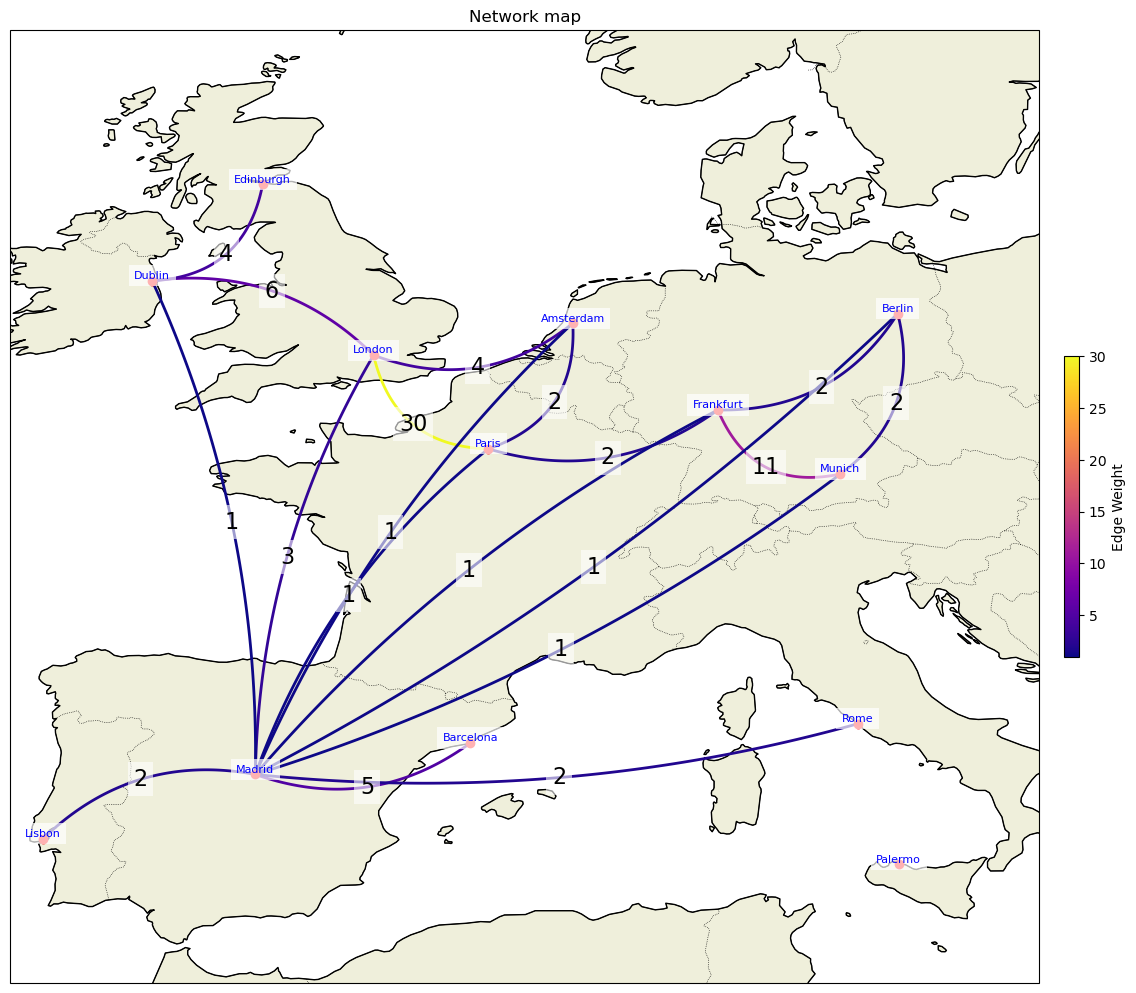

In [136]:
#make a network map
G = nx.Graph()

# Add nodes
for airport in airport_codes:
    airport_dictionaries[airport]['coordinates'] = (
        airport_dictionaries[airport]['Longitude (deg)'],
        airport_dictionaries[airport]['Latitude (deg)']
    )
    G.add_node(airport, pos=airport_dictionaries[airport]['coordinates'])

# Add edges with summed weights across k
for i in airports:
    for j in airports:
        if i != j: 
            total_weight = sum(z[i, j, k].X for k in [0, 1, 2] if z[i, j, k].X > 0)

            if total_weight > 0:
                G.add_edge(
                    airport_codes[i],
                    airport_codes[j],
                    weight=total_weight
                )

positions = nx.get_node_attributes(G, 'pos')

# Extract edge weights
edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]

# Normalize edge weights for color mapping
norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.plasma 

# Create a map projection
fig, ax = plt.subplots(figsize=(16, 13), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-10, 17, 35, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# make the edges curved
def bezier_curve(p0, p1, p2, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1 - t)[:, None]**2 * np.array(p0) + \
            2 * (1 - t)[:, None] * t[:, None] * np.array(p1) + \
            t[:, None]**2 * np.array(p2)
    return curve[:, 0], curve[:, 1]

curvature_factor = 1.5  # Adjust for more or less curvature
for edge in G.edges(data=True):
    start_lon, start_lat = positions[edge[0]]
    end_lon, end_lat = positions[edge[1]]
    weight = edge[2]['weight']
    color = cmap(norm(weight))  # Map weight to color

    # Midpoint for artificial curvature
    mid_lon = (start_lon + end_lon) / 2
    mid_lat = (start_lat + end_lat) / 2

    # Add an offset to the midpoint for curvature
    offset_lon = mid_lat - start_lat  # Perpendicular vector component
    offset_lat = -(mid_lon - start_lon)
    norm_factor = np.sqrt(offset_lon**2 + offset_lat**2)  # Normalize the vector
    offset_lon *= curvature_factor / norm_factor
    offset_lat *= curvature_factor / norm_factor

    curved_lon = mid_lon + offset_lon
    curved_lat = mid_lat + offset_lat

    lons, lats = bezier_curve(
        (start_lon, start_lat), (curved_lon, curved_lat), (end_lon, end_lat)
    )
    ax.plot(lons, lats, color=color, linewidth=2, transform=ccrs.PlateCarree())

    # Display edge weight
    label_lon, label_lat = bezier_curve((start_lon, start_lat), (curved_lon, curved_lat), (end_lon, end_lat), num_points=3)[0][1], bezier_curve((start_lon, start_lat), (curved_lon, curved_lat), (end_lon, end_lat), num_points=3)[1][1]
    ax.text(
        label_lon, label_lat, int(weight),
        fontsize=16, color='black', transform=ccrs.PlateCarree(),
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )
extent = ax.get_extent(crs=ccrs.PlateCarree())
for node, (lon, lat) in positions.items():
    # only plot nodes within the map extent
    if extent[0] <= lon <= extent[1] and extent[2] <= lat <= extent[3]:
        ax.plot(lon, lat, 'o', color='red', transform=ccrs.PlateCarree())

        index = airport_codes.index(node) 
        label = airport_names[index] 

        ax.text(
            lon, lat, label,
            fontsize=8, color='blue', transform=ccrs.PlateCarree(),
            ha='center', va='bottom',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )


# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(edge_weights)

# Adjust the colorbar size and position
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Edge Weight', shrink=0.3, pad=0.02)

plt.title("Network map")
plt.savefig('graph_map.png', dpi=300, bbox_inches='tight')

plt.show()



In [124]:
airport_names

['London',
 'Paris',
 'Amsterdam',
 'Frankfurt',
 'Madrid',
 'Barcelona',
 'Munich',
 'Rome',
 'Dublin',
 'Stockholm',
 'Lisbon',
 'Berlin',
 'Helsinki',
 'Warsaw',
 'Edinburgh',
 'Bucharest',
 'Heraklion',
 'Reykjavik',
 'Palermo',
 'Madeira']

In [95]:
#assignment 2
#import data from excel
group3 = 'Group_3.xlsx'
df_flight = pd.read_excel(group3, sheet_name='Flights', header=0)
df_itineraries = pd.read_excel(group3, sheet_name='Itineraries', header=0).fillna(0)
df_recapture = pd.read_excel(group3, sheet_name='Recapture', header=0)
df_flight
P_p_data = df_recapture.to_numpy()

In [96]:
#define sets
L_no = np.array(df_flight['Flight No.'])
L = range(len(L_no))
P = np.array(range(117))
P_p_ = df_recapture.groupby("From Itinerary")["To Itinerary"].apply(list).to_dict()
for p in P:
    if p not in P_p_:
        P_p_[p] = []


#define parameters
fare = np.array(df_itineraries['Price [EUR]'])
D = np.array(df_itineraries['Demand'])
CAP = np.array(df_flight['Capacity'])

#for the recapture rate, make a 2d array
b = np.zeros((117,117)) 
for i in range(len(P_p_data)):
    b[int(P_p_data[i][0])][int(P_p_data[i][1])] = P_p_data[i][2]
#for travellers staying on their itinerary b=1
for i in range(117):
    for j in range(117):
        if i == j:
            b[i][j] = 1
            
for i in range(117):
    for j in range(117):
        if i == j:
            b[i][j] = 1
            

#make a 2d array for the binary varibale
delta = np.zeros((len(df_itineraries),len(df_flight)))
L_dict = dict(zip(L_no, list(range(len(df_flight)))))
P_data = df_itineraries.to_numpy()
for path in P:
    delta[path][L_dict[P_data[path][3]]] = 1
    if P_data[path][4]:
        delta[path][L_dict[P_data[path][4]]] = 1
        

In [97]:
#add the fictitious itinerary p=117
#adapt sets and parameters
P_f = np.array(range(118))


b_f = np.zeros((118,118))
for i in range(117):
    for j in range(117):
        b_f[i][j] = b[i][j]
        
for i in range(118):
    b_f[i][117] = 1
        

delta_f = np.zeros((len(df_itineraries) + 1,len(df_flight)))
for i in range(len(df_itineraries)):
    for j in range(len(df_flight)):
        delta_f[i][j] = delta[i][j]

fare_f = np.append(fare, 0)

D_f = np.append(D, 0)


In [98]:
#Restricted master Problem
rmp = Model('RestrictedMasterProblem')

#start with ony the columns to the fictitious itinerary
# Decision variables t_p^117
t = {}
for p in P_f:
    r = 117
    t[p, r] = rmp.addVar(
        obj=(fare_f[p] - b_f[p][r]*fare_f[r]),
        lb=0,
        vtype=GRB.CONTINUOUS,
        name = f't_{p}_{r}')

rmp.update()

# Set objective to minimize
rmp.ModelSense = GRB.MINIMIZE

# Add constraints
# Capacity constraints
for i in L:
    r = 117
    rmp.addConstr(
        quicksum(delta_f[p][i] * t[p, r] for p in P_f) >=
        quicksum(delta_f[p][i] * D_f[p] for p in P_f) - CAP[i],
        name=f'capacity_{i}'
    )

#Demand constraints
for p in P_f:
    r = 117
    rmp.addConstr(
        t[p, r] <= D_f[p],
        name=f'demand_{p}'
    )

rmp.update()

# Optimize the model
rmp.optimize()

#track runtime
total_runtime = rmp.Runtime
print(f"Total runtime: {total_runtime:.2f} seconds")

# Extract dual variables
dual_pi = {i: rmp.getConstrByName(f'capacity_{i}').Pi for i in L}
dual_sigma = {p: rmp.getConstrByName(f'demand_{p}').Pi for p in P_f}

# Write LP model to a file for debugging
rmp.write("write.lp")

# Check model status
status = rmp.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL:
    f_objective = rmp.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print(f'Optimization was stopped with status {status}')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 212 rows, 118 columns and 258 nonzeros
Model fingerprint: 0x227c0737
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 203 rows and 99 columns
Presolve time: 0.01s
Presolved: 9 rows, 19 columns, 29 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0997231e+06   1.779431e+02   0.000000e+00      0s
      13    1.2932940e+06   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.293294000e+06
Total runtime: 0.03 seconds
** RESULTS ***

Objective Function Value: 	 1.29329e+06


In [99]:
#track the indexes of flights contained in an itinerary
p_flights = {}
L_dict[0] = 117
for p in P:
    p_flights[p] = [L_dict[P_data[p][3]], L_dict[P_data[p][4]]]  
dual_pi[117] = 0
#calculate the slackness for each combination
c = np.zeros((len(P), len(P)))
columns1 = []
for p in P:
    for r in P_p_[p]:
        c[p][r] = (fare[p] - (dual_pi[p_flights[p][0]] + dual_pi[p_flights[p][1]])) -\
        b[p][r] * (fare[r] - (p_flights[r][0] + p_flights[r][1])) - dual_sigma[p]
        #add columns to next iteration if negative
        if c[p][r] < 0:
            print((p,r))
            columns1.append((p,r))


(18, 19)
(81, 106)
(90, 115)


In [100]:
#next iteration
rmp1 = Model('Iteration2')

t = {}
#columns from first iteration
for p in P_f:
    r = 117
    t[p, r] = rmp1.addVar(
        obj=(fare_f[p] - b_f[p][r]*fare_f[r]),
        lb=0,
        vtype=GRB.CONTINUOUS,
        name = f't_{p}_{r}')
    
#columns from second interation

for c in range(len(columns1)):
    p = columns1[c][0]
    r = columns1[c][1]
    t[p,r] = rmp1.addVar(
        obj=(fare_f[p] - b_f[p][r]*fare_f[r]),
        lb=0,
        vtype=GRB.CONTINUOUS, name=f't_{p}_{r}'
        )
    
rmp1.update()
# Set objective to minimize
rmp1.ModelSense = GRB.MINIMIZE

# Add constraints
# Capacity constraints
for i in L:
    rmp1.addConstr(
        quicksum(delta_f[p][i] * t[p, r] for p in P for r in P_f if (p,r) in t) - 
        quicksum(delta_f[p][i] * b_f[r][p] * t[r, p] for p in P_f for r in P_f if (r,p) in t) >=
        quicksum(delta_f[p][i] * D_f[p] for p in P_f) - CAP[i],
        name=f'capacity_{i}'
    )

#Demand constraints
for p in P_f:
        rmp1.addConstr(quicksum(t[p, r] for r in P_f if (p,r) in t) <= D_f[p],
            name=f'demand_{p}'
        )

rmp1.update()

In [101]:
# Optimize the model
rmp1.optimize()


#track runtime
total_runtime = rmp1.Runtime
print(f"Total runtime: {total_runtime:.2f} seconds")

# Extract dual variables
dual_pi = {i: rmp1.getConstrByName(f'capacity_{i}').Pi for i in L}
dual_sigma = {p: rmp1.getConstrByName(f'demand_{p}').Pi for p in P_f}

# Write LP model to a file for debugging
rmp1.write("write.lp")

# Check model status
status = rmp1.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL:
    f_objective = rmp1.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print(f'Optimization was stopped with status {status}')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 212 rows, 121 columns and 269 nonzeros
Model fingerprint: 0x11054bf3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [4e+01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 203 rows and 102 columns
Presolve time: 0.01s
Presolved: 9 rows, 19 columns, 29 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0997231e+06   1.779431e+02   0.000000e+00      0s
      13    1.2932940e+06   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.293294000e+06
Total runtime: 0.02 seconds
** RESULTS ***

Objective Function Value: 	 1.29329e+06


In [102]:
#calculate slackness
c1 = np.zeros((len(P), len(P)))
columns2 = []
for p in P:
    for r in P_p_[p]:
        c1[p][r] = sum((delta[p][i] - delta[r][i] * b[r][p]) * dual_pi[i] for i in I) + dual_sigma[p] - fare[p] - b[p][r] * fare[r]
        #add columns to next iteration if negative
        if c1[p][r] < 0 and (p,r) not in columns1:
            columns2.append((p,r))

In [103]:
#next iteration
rmp2 = Model('Iteration3')
t = {}

#columns from first iteration
for p in P_f:
    r = 117
    t[p, r] = rmp2.addVar(
        obj=(fare_f[p] - b_f[p][r]*fare_f[r]),
        lb=0,
        vtype=GRB.CONTINUOUS,
        name = f't_{p}_{r}')
    
#columns from second iteration
for c in range(len(columns1)):
    p = columns1[c][0]
    r = columns1[c][1]
    t[p,r] = rmp2.addVar(
        obj=(fare_f[p] - b_f[p][r]*fare_f[r]),
        lb=0,
        vtype=GRB.CONTINUOUS, name=f't_{p}_{r}'
        )

#columns from third iteration
for c in range(len(columns2)):
    p = columns2[c][0]
    r = columns2[c][1]
    t[p,r] = rmp2.addVar(
        obj=(fare_f[p] - b_f[p][r]*fare_f[r]),
        lb=0,
        vtype=GRB.CONTINUOUS, name=f't_{p}_{r}'
        )
    
rmp1.update()

# Set objective to minimize
rmp2.ModelSense = GRB.MINIMIZE

# Add constraints
# Capacity constraints
for i in L:
    rmp2.addConstr(
        quicksum(delta_f[p][i] * t[p, r] for p in P for r in P_f if (p,r) in t) - 
        quicksum(delta_f[p][i] * b_f[r][p] * t[r, p] for p in P_f for r in P_f if (r,p) in t) >=
        quicksum(delta_f[p][i] * D_f[p] for p in P_f) - CAP[i],
        name=f'capacity_{i}'
    )

#Demand constraints
for p in P_f:
        rmp2.addConstr(quicksum(t[p, r] for r in P_f if (p,r) in t) <= D_f[p],
            name=f'demand_{p}'
        )

rmp2.update()

In [104]:
# Optimize the model
rmp2.optimize()

#track runtime
total_runtime = rmp2.Runtime
print(f"Total runtime: {total_runtime:.2f} seconds")

# Extract dual variables
dual_pi = {i: rmp1.getConstrByName(f'capacity_{i}').Pi for i in L}
dual_sigma = {p: rmp1.getConstrByName(f'demand_{p}').Pi for p in P_f}

# Write LP model to a file for debugging
rmp2.write("write.lp")

# Check model status
status = rmp2.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL:
    f_objective = rmp2.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print(f'Optimization was stopped with status {status}')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 212 rows, 283 columns and 758 nonzeros
Model fingerprint: 0x8252ec5f
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [4e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 106 rows and 55 columns
Presolve time: 0.01s
Presolved: 106 rows, 230 columns, 587 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7086574e+05   7.432198e+02   0.000000e+00      0s
      77    1.2385822e+06   0.000000e+00   0.000000e+00      0s

Solved in 77 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.238582204e+06
Total runtime: 0.02 seconds
** RESULTS ***

Objective Function Value: 	 1.23858e+06


In [105]:
#calculate slackness for third iteration
c2 = np.zeros((len(P), len(P)))
columns3 = []
for p in P:
    for r in P_p_[p]:
        c2[p][r] = sum((delta[p][i] - delta[r][i] * b[r][p]) * dual_pi[i] for i in I) + dual_sigma[p] - fare[p] - b[p][r] * fare[r]
        #add columns to next iteration if negative
        if c2[p][r] < 0 and (p,r) not in (columns2 + columns1):
            columns3.append((p,r))
            print(p,r)
if not columns3:
    print('no more columns to be added')

no more columns to be added


In [112]:
#calculate and recaptured and spilled passengers

print('the recaptured passengers are: \n')
for (p,r) in t:
    if t[p,r].X > 0 and r != 117:
        print('from path ', p, 'to path ', r, ' is ', b_f[p][r] * t[p,r].X)

print('\n the spilled passengers are \n')  
for (p,r) in t:
    if t[p,r].X > 0 and r == 117:
        print('from path ', p,  ' is ', b_f[p][r] * t[p,r].X)
        
print('\n')
#sum all spilled passengers
spill = 0
for p in P:
    spill += b_f[p][117] * t[p,117].X
print('total amount of spilled passengers: ', spill, '\n')

print('optimal decision variables associated with the first 5 itineraries: \n')
#optimal decision variables associated with the first 5 passenger iteneraries
for p in range(5):
    for r in P:
        if (p,r) in t:
            print('from path ', p, 'to path ', r, ' is ', t[p,r].X)

the recaptured passengers are: 

from path  0 to path  6  is  18.0
from path  1 to path  2  is  4.4399999999999995
from path  2 to path  6  is  86.72042898550724
from path  2 to path  10  is  34.0
from path  5 to path  4  is  15.0
from path  5 to path  9  is  8.219999999999999
from path  7 to path  3  is  8.97
from path  11 to path  9  is  7.22
from path  14 to path  12  is  21.0
from path  14 to path  13  is  3.3513978494623644
from path  14 to path  17  is  30.0
from path  15 to path  13  is  29.099999999999998
from path  20 to path  21  is  40.81
from path  21 to path  22  is  70.1145
from path  23 to path  22  is  12.21
from path  24 to path  33  is  89.14597490149254
from path  25 to path  24  is  43.20154746268658
from path  25 to path  32  is  28.999999999999996
from path  26 to path  25  is  24.5
from path  27 to path  28  is  53.980000000000004
from path  27 to path  35  is  9.0
from path  28 to path  25  is  13.286000000000001
from path  29 to path  33  is  27.560000000000002

In [91]:
#keypath formulation
kp = Model('Keypath')

# all decision variables
t = {}
for p in P:
    for r in P:
        t[p, r] = kp.addVar(
            obj=(fare[p] - b[p][r]*fare[r]),
            lb=0,
            vtype=GRB.CONTINUOUS,
            name = f't_{p}_{r}')

kp.update()

# Set objective to minimize
kp.ModelSense = GRB.MINIMIZE

# Add constraints
# Capacity constraints
for i in L:
    kp.addConstr(
        quicksum(delta[p][i] * t[p, r] for p in P for r in P) - 
        quicksum(delta[p][i] * b[r][p] * t[r,p] for r in P for p in P) >=
        quicksum(delta[p][i] * D[p] for p in P) - CAP[i],
        name=f'capacity_{i}'
    )

#Demand constraints
for p in P:
    kp.addConstr(quicksum(t[p, r] for r in P) <= D[p], name=f'demand_{p}')

kp.update()

# Optimize the model
kp.optimize()

#track runtime
total_runtime = kp.Runtime
print(f"Total runtime: {total_runtime:.2f} seconds")

# Write LP model to a file for debugging
kp.write("write.lp")

# Check model status
status = kp.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL:
    f_objective = kp.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print(f'Optimization was stopped with status {status}')

KeyboardInterrupt: 

In [103]:
pmf = Model('passenger mix flow')

x = {} #number of passengers from p on r

for p in P:
    for r in P:
        x[p, r] = pmf.addVar(obj=fare[r], lb=0, vtype=GRB.INTEGER, name = f'x_{p}_{r}')
        
pmf.update()
pmf.setObjective(pmf.getObjective(), GRB.MAXIMIZE)

#add constraints
for i in L:
    pmf.addConstr(quicksum(delta[r][i] * x[p, r] for p in P for r in P) <= CAP[i])
    
#for p in P:
#    for r in P:
#        pmf.addConstr(x[p, r] <= D[p] * b[p][r])
for p in P:
    pmf.addConstr(quicksum(x[p,r] * b[p][r]**-1 for r in P_p[p]) <= D[p])

# Add recapture constraint: x[p, r] = 0 if b[p][r] = 0
for p in P:
    for r in P:
        if b[p][r] == 0:
            pmf.addConstr(x[p, r] == 0)


pmf.update()
pmf.optimize()
status = pmf.status
pmf.write('pmf_write.lp')

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = pmf.objVal
    print('** RESULTS ***')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)

NameError: name 'P_p' is not defined

In [ ]:
xsum=0
for p in P:
    for r in P:
        if x[p,r].X > 0:
            print('from path ', p, 'to path', r, 'is ', x[p,r].X)
            xsum += x[p,r].X


In [721]:
# Dictionary to store occupation per flight
flight_occupation = {}

# Compute occupation for each flight i
for i in L:
    flight_occupation[i] = sum(delta[r][i] * x[p, r].X for p in P for r in P if x[p, r].X > 0)

# Print the results
#print("Flight Occupations:")
#for i, occ in flight_occupation.items():
#    print(f"Flight {i}: {occ} passengers")